In [77]:
from pathlib import Path
import os
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gym_recording_modified.playback import get_recordings
from utils.data_extractors import *
from utils.visualizations import *
import seaborn as sns
from scipy.stats import sem
from scipy.signal import convolve2d

In [78]:
def extract_num_episodes(root: str, param_names: list, filters=None, cutoffs=None):
    """
    Extract number of episodes

    args
        root : directory where results are stored
        param_names : a list of parameters to extract for each run, stored in params.json 
        env: which environment to extract this for
    """

    all_episodes = []
    all_params = []

    for dir in tqdm(root.iterdir()):    
        params_file = dir/'params.json'               
        params = json.load(open(params_file))
        params_run  = [] # relevant parameters for a single run
        env = params['env']

        filter = False
        for p in param_names:
            params_run.append(params.get(p, None))
            value = params.get(p, None)

            if filters is not None:
                allowed_values = filters.get(p)
                if allowed_values is not None and value not in allowed_values:
                    filter = True

        if filter == False:
            all_params.append(params_run)
            episode_len = np.load(dir/"episode_lengths.npy")

            if cutoffs is not None:
                episodes_completed = np.sum(episode_len != cutoffs[env])
            else:
                episodes_completed  = episode_len.shape[0]

            all_episodes.append(episodes_completed)
    
    return np.array(all_params),  np.array( all_episodes)

In [79]:
root = Path('results_new_sweep')
filters = {
    'buffer_size' : [10000],
    'env': ['envs:random_maze-v0', 'CartPole-v1']}

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, num_episodes = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)

16200it [01:14, 216.32it/s]


In [80]:
df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df = pd.concat([df1, df2], axis=1)
df.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Num Episodes']
df = df.drop(['Seed'],axis=1)
df['Algorithm'] = df['Model'] + ', ' + df['L'] 
df = df.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df = df.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df = df.replace('FFN, 10', 'DQN')
df = df.replace('FFN, 1', 'DQN')

df = df.replace('RNN, 1', 'DRQN, 1')
df = df.replace('RNN, 2', 'DRQN, 2')
df = df.replace('RNN, 4', 'DRQN, 4')
df = df.replace('RNN, 8', 'DRQN, 8')


In [81]:
df_mean = df.groupby(columns).mean().reset_index() # dataframe with mean over seeds for each parameter/alg/env configuration

# Total Number of episodes completed for all hyperparameters

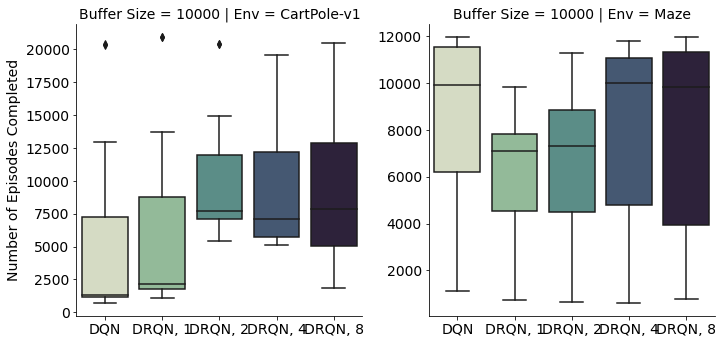

In [82]:
# Box plots of average number of episodes completed for all algorithms
g = sns.catplot(x='Algorithm', y='Num Episodes', row='Buffer Size', col='Env', data=df_mean, kind='box', sharey=False, palette= sns.cubehelix_palette(5, start=.5, rot=-.75).as_hex())
g.set_axis_labels("", "Number of Episodes Completed")
plt.savefig('figures/sensitivity.pdf', bbox_inches='tight')

In [83]:
def n_best_params(df, env, alg, n, columns, metric, maximize=True):
    '''
    returns the n best hyperparameter of alg on env accroding to metric column in df
    if maximize = True then higher numbers are better
    '''
    df_env_alg = df.loc[(df['Env'] == env) & (df['Algorithm'] ==alg)] # filtered by env and alg
    if maximize:
        df_env_alg = df_env_alg.nlargest(n, metric)
    else:
        df_env_alg = df_env_alg.nsmallest(n, metric)

    df_env_alg = df_env_alg.set_index(columns)
    inds = df_env_alg.index.tolist()

    return inds

In [84]:
def get_best_data(df, df_mean, columns, metric):
    '''
    Filters a dataframe to only include data from the best hyperparameters, as determined by df_mean
    '''
    inds = []
    for env in df['Env'].unique():
        for alg in df['Algorithm'].unique():
            if env == 'CartPole-v1': # fewer episodes completed is better for cartpole
                maximize = False
            else:
                maximize = True

            inds += n_best_params(df_mean, env, alg, 1, columns, metric, maximize=maximize)
    
    df_ = df.set_index(columns)
    df_ = df_.loc[inds]
    return df_.reset_index(), inds

## Total Number of episodes completed for best hyperparameters

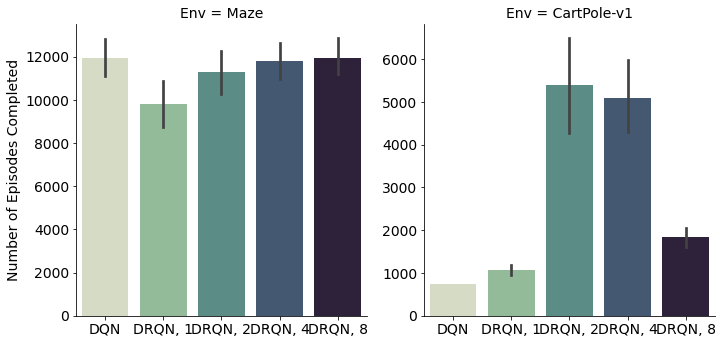

In [85]:
df_best, best_inds = get_best_data(df, df_mean, columns, 'Num Episodes')
g = sns.catplot(x='Algorithm', y='Num Episodes', col='Env', data=df_best, kind='bar', ci=68, sharey=False, palette= sns.cubehelix_palette(5, start=.5, rot=-.75))
g.set_axis_labels("", "Number of Episodes Completed")
plt.savefig('figures/total_episodes_best_params.pdf', bbox_inches='tight')

In [86]:
best_inds

[('DQN', 'Maze', '1', '10', '5e-05', '10000'),
 ('DRQN, 1', 'Maze', '1', '1', '0.0005', '10000'),
 ('DRQN, 2', 'Maze', '1', '100', '0.0005', '10000'),
 ('DRQN, 4', 'Maze', '1', '100', '5e-05', '10000'),
 ('DRQN, 8', 'Maze', '1', '1', '5e-05', '10000'),
 ('DQN', 'CartPole-v1', '1', '100', '0.0005', '10000'),
 ('DRQN, 1', 'CartPole-v1', '10', '100', '0.005', '10000'),
 ('DRQN, 2', 'CartPole-v1', '10', '1000', '0.005', '10000'),
 ('DRQN, 4', 'CartPole-v1', '1', '100', '5e-05', '10000'),
 ('DRQN, 8', 'CartPole-v1', '10', '1000', '0.005', '10000')]

## average episode length for best hyperparameters last 50 episodes

In [87]:
def extract_epsisode_lengths(root: str, param_names: list, filters=None, cutoffs=None, last_n=False):
    """
    Extract epsiode lengths

    args
        root : directory where results are stored
        param_names : a list of parameters to extract for each run, stored in params.json 
        env: which environment to extract this for
    """
    def cutoff(episode_len, cutoff):
        new_episode_len = []
        current_len = 0
        for i in episode_len:
            current_len += i
            if i != cutoff: 
                new_episode_len.append(current_len)
                current_len = 0

        return new_episode_len

    all_episodes = []
    all_params = []

    for dir in tqdm(root.iterdir()):    
        params_file = dir/'params.json'               
        params = json.load(open(params_file))
        params_run  = [] # relevant parameters for a single run
        env = params['env']

        filter = False
        for p in param_names:
            params_run.append(params.get(p, None))
            value = params.get(p, None)
            
            if filters is not None:
                allowed_values = filters.get(p)
                if allowed_values is not None and value not in allowed_values:
                    filter = True

        if filter == False:
            all_params.append(params_run)
            episode_len = np.load(dir/"episode_lengths.npy")

            if cutoffs is not None:
                # add cut off episodes to subsequent
                episode_len = cutoff(episode_len, cutoffs[env])

            if last_n:
                all_episodes.append(episode_len[-last_n:])
            else:
                all_episodes.append(episode_len)
    
    return np.array(all_params), np.array( all_episodes)

In [88]:
root = Path('results_new_sweep')
filters = {
    'buffer_size' : [10000],
    'env': ['envs:random_maze-v0', 'CartPole-v1']}

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, episode_len = extract_epsisode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs, last_n=50)

# do_avg = np.vectorize(np.mean)
# episode_len = do_avg(episode_len) 
#episode_len = np.mean(episode_len, axis=1)

avg = np.zeros(episode_len.shape[0])
for i in range(episode_len.shape[0]):
    avg[i] = np.mean(episode_len[i])

df1 = pd.DataFrame(params)
df2 = pd.DataFrame(avg)
df_last = pd.concat([df1, df2], axis=1)
df_last.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Average Episode Length']
df_last = df_last.drop(['Seed'],axis=1)
df_last['Algorithm'] = df_last['Model'] + ', ' + df_last['L'] 
df_last = df_last.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_last = df_last.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df_last = df_last.replace('FFN, 10', 'DQN')
df_last = df_last.replace('FFN, 1', 'DQN')

df_last = df_last.replace('RNN, 1', 'DRQN, 1')
df_last = df_last.replace('RNN, 2', 'DRQN, 2')
df_last = df_last.replace('RNN, 4', 'DRQN, 4')
df_last = df_last.replace('RNN, 8', 'DRQN, 8')


16200it [00:52, 309.20it/s] 


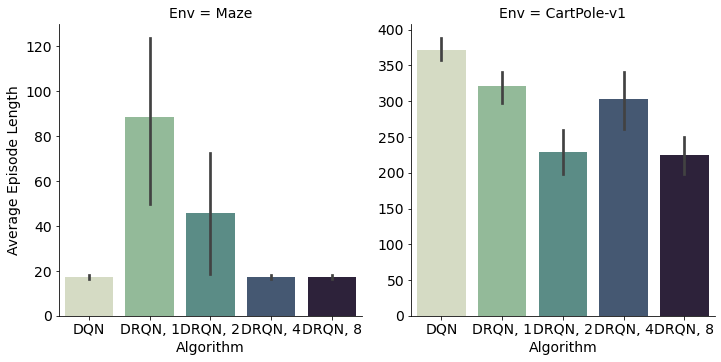

In [89]:
# 50
df_best_last, best_inds = get_best_data(df_last, df_mean, columns, 'Num Episodes') # performance metric for determining best parameters is still num episodes
g = sns.catplot(x='Algorithm', y='Average Episode Length', col='Env', data=df_best_last, kind='bar', ci=68,  sharey=False, palette= sns.cubehelix_palette(5, start=.5, rot=-.75))
plt.savefig('figures/last_50_length_best_params.pdf', bbox_inches='tight')

In [93]:
df_best

,Algorithm,Env,Learning Freq.,Target Update Freq.,Step Size,Buffer Size,Num Episodes
0,DQN,Maze,1,10,5e-05,10000,11263
1,DQN,Maze,1,10,5e-05,10000,11437
2,DQN,Maze,1,10,5e-05,10000,8864
3,DQN,Maze,1,10,5e-05,10000,8979
4,DQN,Maze,1,10,5e-05,10000,9006
...,...,...,...,...,...,...,...
295,"DRQN, 8",CartPole-v1,10,1000,0.005,10000,2007
296,"DRQN, 8",CartPole-v1,10,1000,0.005,10000,2923
297,"DRQN, 8",CartPole-v1,10,1000,0.005,10000,3839
298,"DRQN, 8",CartPole-v1,10,1000,0.005,10000,1668


In [90]:
df_temp = pd.concat([df_best_last.set_index(columns), df_best.set_index(columns)], axis=1)
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['Learning Freq.', 'Target Update Freq.',  'Step Size', 'Buffer Size'], axis=1)
df_temp = df_temp.melt(id_vars=['Algorithm', 'Env'], var_name = 'source', value_name='val')

[744.6333333333333, 1075.1666666666667, 5400.866666666667, 5088.2, 1833.3666666666666]
[371.6573333333333, 321.20466666666664, 228.61133333333336, 303.19066666666663, 224.5206666666667]
[11952.466666666667, 9821.833333333334, 11284.666666666666, 11815.3, 11960.7]
[17.229333333333336, 88.30066666666666, 45.635999999999996, 17.227333333333334, 17.317333333333334]


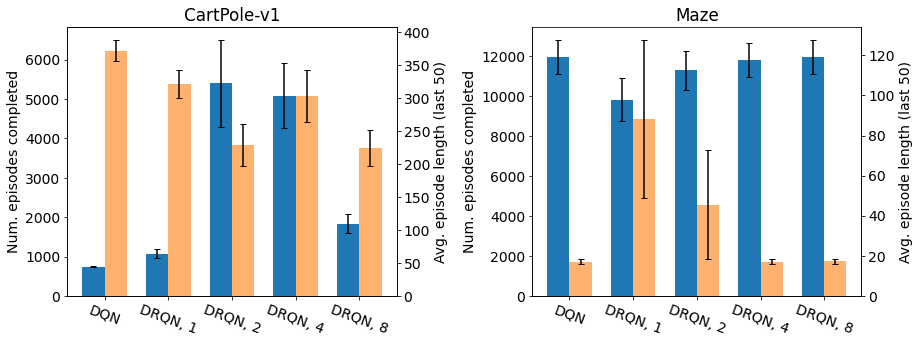

In [92]:
# double bar plot

font = {'size'   : 14}

matplotlib.rc('font', **font)
env_ind = 1

data = df_temp.values


algs =  np.unique(data[:, 0])
envs = np.unique(data[:, 1])

num_subplots = envs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(13,5))


x = np.arange(len(algs))  # the label locations
width = 0.35  # the width of the bars

ax_idx = 0

colours = sns.cubehelix_palette(len(algs), start=.5, rot=-.75).as_hex()


for env in envs:
    ax = axs[ax_idx]
    data_num_episodes_to_plot = []
    data_ep_len_to_plot = []
    num_episodes_err = []
    ep_len_err = []
    scale = 1


    for alg in algs:
        data_num_episodes = data[np.where((data[:, 2] == 'Num Episodes') & (data[:, 1] ==env) & (data[:, 0] == alg))]
        data_ep_len = data[np.where((data[:, 2] == 'Average Episode Length') & (data[:, 1] ==env) & (data[:, 0] == alg))]       

        data_num_episodes_to_plot.append(np.mean(data_num_episodes[:, 3]))
        data_ep_len_to_plot.append(np.mean(data_ep_len[:, 3]* scale ))
        num_episodes_err.append(sem(data_num_episodes[:, 3]))
        ep_len_err.append(sem(data_ep_len[:, 3]))

    rects1 = ax.bar(x - width/2, data_num_episodes_to_plot, width, label='Num Episodes', color='tab:blue' )
    ax.errorbar(x - width/2, data_num_episodes_to_plot, yerr=num_episodes_err, ecolor='black', capsize=3, ls='none' )

    print(data_num_episodes_to_plot)
    print(data_ep_len_to_plot)

    ax.set_ylabel('Num. episodes completed')
    ax.set_title(env)
    ax.set_xticks(x)
    ax.set_xticklabels(algs, rotation=340)
    ax2 = ax.twinx()
    ax2.set_ylabel('Avg. episode length (last 50)')

    rects2 = ax2.bar(x + width/2, data_ep_len_to_plot, width, label='Last 50 Episode Avg. Episode Length', color='tab:orange', alpha = 0.6)
    ax2.errorbar(x + width/2, data_ep_len_to_plot, yerr=ep_len_err, ecolor='black', capsize=3, ls='none' )
    ax_idx += 1

handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')
plt.xticks(rotation=290)
plt.gca().spines['top'].set_visible(False)
fig.tight_layout()
plt.show()


In [24]:
# learning curves
root = Path('results_test')
filters = {
    'buffer_size' : [10000],
    'env': ['envs:random_maze-v0', 'CartPole-v1']}

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, episode_len = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)


31it [00:00, 271.85it/s]


[   856   2125   2767 ... 199037 199091 199347]
[   1    2    3 ... 3680 3681 3682]


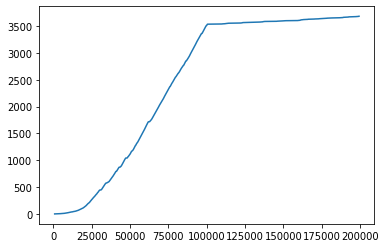

In [25]:

for i in range(1):
    episode_len[i] = np.cumsum(episode_len[i])
    
    y = np.arange(1, len(episode_len[i])+1)

    print(episode_len[i])
    print(y)

    plt.plot(episode_len[i], y)

    

